Much data produced is unlabeled data, data where the target vale or class is unknown.  Unsupervised learning gives us the tools to find hidden structure in unlabeled data.  There are many techniques, one of which is clustering of the data.  [Clustering](https://en.wikipedia.org/wiki/Cluster_analysis) is a method that places objects that are more similar into the same group.  One of the steps in clustering is to determine the "correct" number of cluster.  There are several diagnostics for this step, three of which will be shown in this post.   In doing this exercise, we will demonstrate the use of [kmeans clustering](https://en.wikipedia.org/wiki/K-means_clustering) using H2O's Python API and how to retrieve results of the modeling work from H2O.

Our first step is to import the H2O Python library start the H2O engine.  H2O.ai provides detailed [documentation](http://docs.h2o.ai/) about the Python API and the rest of H2O.  When H2O is started it provides summary information about the amount of memory and number of cores being used by the H2O engine.

In [11]:
import h2o

In [12]:
# Start a local instance of the H2O engine.
h2o.init();

H2O cluster uptime:,6 minutes 749 milliseconds
H2O cluster version:,3.0.1.4
H2O cluster name:,H2O_started_from_python
H2O cluster total nodes:,1
H2O cluster total memory:,3.56 GB
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster healthy:,True
H2O Connection ip:,127.0.0.1
H2O Connection port:,54321


The next step of using H2O is to parse and load data into H2O's in-memory columnar compressed storage.  Today we will be using the [Iris flower data set](https://en.wikipedia.org/wiki/Iris_flower_data_set).

In [31]:
iris = h2o.import_frame(path="https://github.com/h2oai/h2o-3/raw/master/h2o-r/h2o-package/inst/extdata/iris_wheader.csv")


Parse Progress: [##################################################] 100%
Imported https://github.com/h2oai/h2o-3/raw/master/h2o-r/h2o-package/inst/extdata/iris_wheader.csv. Parsed 150 rows and 5 cols


H2O provides convenient commands to understand the H2OFrame object, the data structure for data that will be used by H2O's machine learning algorithms.  Because H2O is often used for very large datasets and in a cluster computing configuration information about how much the data is compressed in memory and the distribution of the data across the H2O nodes, along with standard summary statics on the data in the H2OFrame, is provided.

In [32]:
iris.describe()

Rows: 150 Cols: 5

Chunk compression summary:



chunk_type,chunk_name,count,count_percentage,size,size_percentage
C1,1-Byte Integers,1,20.0,218 B,18.890814
C1S,1-Byte Fractions,4,80.0,936 B,81.109184



Frame distribution summary:



,size,number_of_rows,number_of_chunks_per_column,number_of_chunks
127.0.0.1:54321,1.1 KB,150.0,1.0,5.0
mean,1.1 KB,150.0,1.0,5.0
min,1.1 KB,150.0,1.0,5.0
max,1.1 KB,150.0,1.0,5.0
stddev,0 B,0.0,0.0,0.0
total,1.1 KB,150.0,1.0,5.0



Column-by-Column Summary:



,sepal_len,sepal_wid,petal_len,petal_wid,class
type,real,real,real,real,enum
mins,4.3,2.0,1.0,0.1,0.0
maxs,7.9,4.4,6.9,2.5,2.0
sigma,0.828066127978,0.433594311362,1.76442041995,0.763160741701,0.819231920519
zero_count,0,0,0,0,50
missing_count,0,0,0,0,0


The iris data set is labeled into three classes; there are four measurements that were taken for each iris.  While we will not be using the labeled data for clustering, it does provide us a convenient comparison and visualization of the data as it was provided.  In this example I use [Seaborn](http://stanford.edu/~mwaskom/software/seaborn/) for the visualization of the data.

<sub><sup>(As an aside, the approach taken here of using all the data for visualization does not scale to large datasets.  One approach to dealing with large data sets is to sample the data in H2O and then transfer the sample of data to the Python environment for plotting).</sup></sub>

In [25]:
import pandas as pd
import seaborn as sns
%matplotlib inline
sns.set()

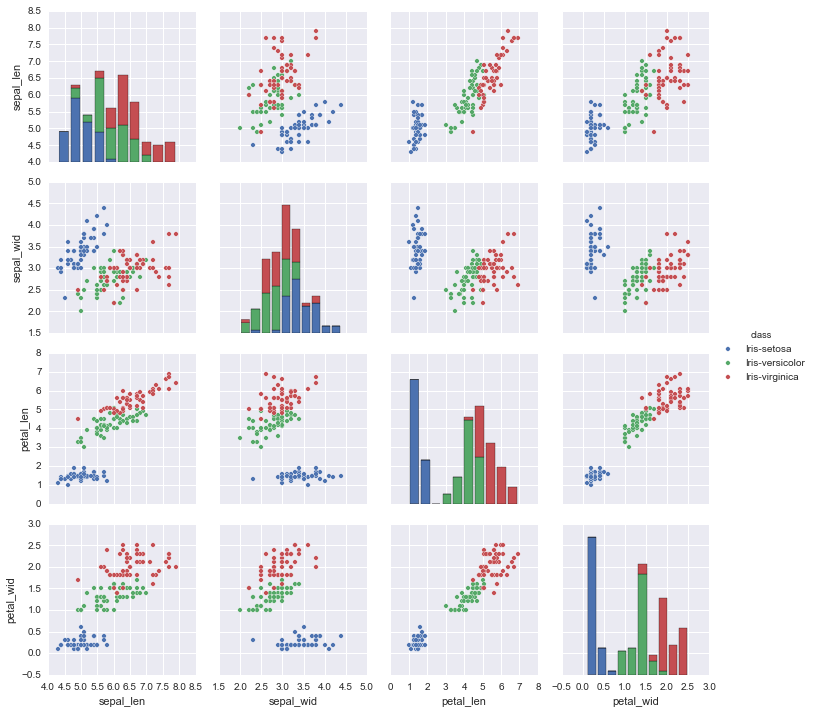

In [90]:
sns.set_context("notebook")
sns.pairplot(iris.as_data_frame(), vars=["sepal_len", "sepal_wid", "petal_len", "petal_wid"], hue="class");

The next step is to model the data using H2O's kmeans algorithm.  We will do this across a range of cluster options and collect each H2O model object as an element in an array.  In this example the initial position of the cluster centers is selected at random and the random number seed is set for reproducibility.  Because H2O is designed for high performance it is quick and easy to explore many different hyper-parameter settings during modeling to find the model that best suits your needs.

In [83]:
results = [ h2o.kmeans(x=iris[0:-1], k=clusters, init="Random", seed=2, standardize=True) for clusters in range(2,13)]


kmeans Model Build Progress: [##################################################] 100%

kmeans Model Build Progress: [##################################################] 100%

kmeans Model Build Progress: [##################################################] 100%

kmeans Model Build Progress: [##################################################] 100%

kmeans Model Build Progress: [##################################################] 100%

kmeans Model Build Progress: [##################################################] 100%

kmeans Model Build Progress: [##################################################] 100%

kmeans Model Build Progress: [##################################################] 100%

kmeans Model Build Progress: [##################################################] 100%

kmeans Model Build Progress: [##################################################] 100%

kmeans Model Build Progress: [##################################################] 100%


There are three diagnostics that will be demonstrated to help with determining the number of clusters: total within cluster sum of squares, AIC, and BIC.

Total within cluster sum of squares measures sums the distance from each point in a cluster to that point's assigned cluster center.  This is the minimization criteria of kmeans.  The standard guideline for picking the number of clusters is to look for a 'knee' in the plot, showing where the total within sum of squares stops decreasing rapidly.  Total within cluster sum of squares can be difficult to intepret, with the criteria being to look for an arbitrary knee in the plot.  

With this challenge from total within cluster sum of squares, we will also use two merit statistics for determining the number of clusters.  [AIC](https://en.wikipedia.org/wiki/Akaike_information_criterion) and [BIC](https://en.wikipedia.org/wiki/Bayesian_information_criterion) are both measures of the relative quality of a statistical model.  AIC and BIC introduce penality terms for the number of parameters in the model to counter the problem of overfitting; BIC has a larger penality term than AIC.  With these merit statistics one is to look for the number of clusters that minimize the statistic.

Here we build a method for extracting the inputs for each diagnostics and calculating the AIC and BIC values  on a model.  Each model is then inspected by the method and the results plotted for quick analysis.

In [84]:
import math as math

def diagnostics_from_clusteringmodel(model):
    total_within_sumofsquares = model.tot_withinss()
    number_of_clusters = len(model.centers())
    number_of_dimensions = len(model.centers()[0])
    number_of_rows = sum(model.size())
    
    aic = total_within_sumofsquares + 2 * number_of_dimensions * number_of_clusters
    bic = total_within_sumofsquares + math.log(number_of_rows) * number_of_dimensions * number_of_clusters
    
    return {'Clusters':number_of_clusters,
            'Total Within SS':total_within_sumofsquares, 
            'AIC':aic, 
            'BIC':bic}

In [85]:
diagnostics = pd.DataFrame( [diagnostics_from_clusteringmodel(model) for model in results])
diagnostics.set_index('Clusters', inplace=True)

From the plot below, to me, it is difficult to find a 'knee' in the rate of decrease of the total within cluster sum of square.  It might be at 4 clusters, it might be 7.  AIC is minimized at 7 clusters, and BIC is minimized at 4 clusters.

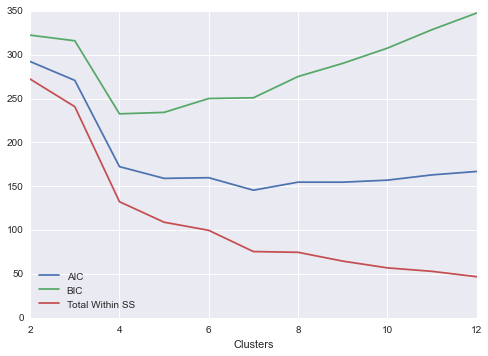

In [86]:
diagnostics.plot(kind='line');

For demonstration purposes, I will selected the number of clusters to be 4.  I will use the H2O Model for 4 clusters previously created, and use that to assign the membership in each of the original data points.  This predicted cluster assignment is then added to the original iris data frames as a new vector (mostly to make plotting easy).

In [87]:
clusters = 4
predicted = results[clusters-2].predict(iris)
iris["Predicted"] = predicted["predict"].asfactor()

Finally, I will plot the predicted cluster membership using the same layout as on the original data earlier in the notebook.  

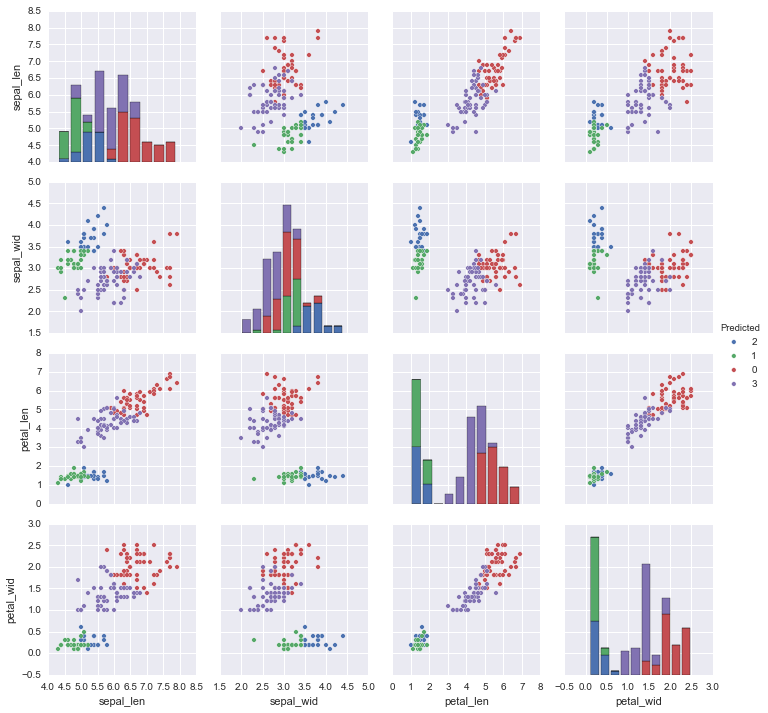

In [89]:
sns.pairplot(iris.as_data_frame(), vars=["sepal_len", "sepal_wid", "petal_len", "petal_wid"],  hue="Predicted");

This iPython notebook is available for [download]().  Grab the [latest version of H2O](http://h2o.ai/download/) to try it out. 

-- [Hank](http://twitter.com/hankroark)